I've always been curious about the population growth of India (my home country). I wondered how easy or difficult it would be to model population growth using common time series analyses methods. This is an experiment to see how well different approaches work. 

In [390]:
import pandas as pd
from pandas import Series
import matplotlib
import statsmodels.api as sm
import numpy as np
from math import sqrt
import scipy 
import chardet
from matplotlib import pyplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import ar_select_order

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Getting Some population data from the world bank. We've removed some headers from the original spreadsheet, and saved it with utf encoding to avoid any encoding issues while reading.

In [149]:
file = "/home/jovyan/work/API_SP.POP.TOTL_DS2_en_csv_v2_3469297.csv"
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [35]:
df = pd.read_csv(file,encoding=result['encoding'])

In [36]:
df.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN
5,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837743.0,NaN
6,Andorra,AND,"Population, total",SP.POP.TOTL,13410.0,14378.0,15379.0,16407.0,17466.0,18542.0,...,82427.0,80770.0,79213.0,77993.0,77295.0,76997.0,77008.0,77146.0,77265.0,NaN
7,Arab World,ARB,"Population, total",SP.POP.TOTL,92197715.0,94724540.0,97334438.0,100034191.0,102832792.0,105736428.0,...,371437642.0,379696477.0,387899835.0,396028301.0,404042892.0,411942825.0,419851989.0,427870273.0,436080728.0,NaN
8,United Arab Emirates,ARE,"Population, total",SP.POP.TOTL,92417.0,100801.0,112112.0,125130.0,138049.0,149855.0,...,9141598.0,9197908.0,9214182.0,9262896.0,9360975.0,9487206.0,9630966.0,9770526.0,9890400.0,NaN
9,Argentina,ARG,"Population, total",SP.POP.TOTL,20481781.0,20817270.0,21153042.0,21488916.0,21824427.0,22159644.0,...,41733271.0,42202935.0,42669500.0,43131966.0,43590368.0,44044811.0,44494502.0,44938712.0,45376763.0,NaN


In [99]:
india = df[df['Country Name']=='India']
india

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
109,India,IND,"Population, total",SP.POP.TOTL,450547675.0,459642166.0,469077191.0,478825602.0,488848139.0,499123328.0,...,1.265780e+09,1.280842e+09,1.295601e+09,1.310152e+09,1.324517e+09,1.338677e+09,1.352642e+09,1.366418e+09,1.380004e+09,NaN


In [252]:
it = india.transpose()
it = it.drop(['Country Name','Country Code','Indicator Name','Indicator Code'])
it = it.reset_index()

In [253]:
it = it.rename(columns={'index':'year',it.columns[1]:'population'})
it = it.dropna()

<AxesSubplot:xlabel='year'>

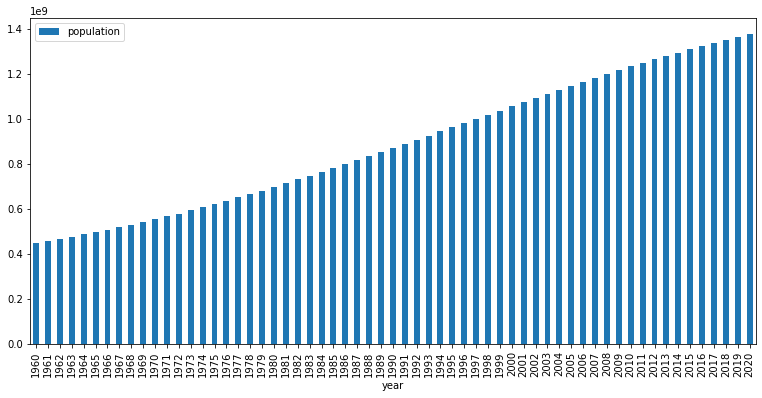

In [294]:
it.plot(kind='bar',x='year',y='population',figsize=(13,6))

<h3> Using Linear Regression </h3>

This is a naive solution that attemtps to learn a relationship between population and year and use that regression line to predict population at a later time. 

In [345]:
#Getting X and Y into 2D array shape as required by linear regression 
X = it['year'].values.reshape(-1,1)
Y = it['population'].values.reshape(-1,1)
#splitting into train and test
size = int(len(X) * 0.9)
trainX, testX = X[0:size], X[size:len(X)]
trainY, testY = Y[0:size], Y[size:len(Y)]
#creating the model based on 54 years of data
model = LinearRegression().fit(trainX,trainY)
Y_Pred = model.predict(testX)
testY,Y_Pred

(array([[1295600768.0],
        [1310152392.0],
        [1324517250.0],
        [1338676779.0],
        [1352642283.0],
        [1366417756.0],
        [1380004385.0]], dtype=object),
 array([[1.28140066e+09],
        [1.29779689e+09],
        [1.31419312e+09],
        [1.33058934e+09],
        [1.34698557e+09],
        [1.36338180e+09],
        [1.37977803e+09]]))

In [369]:
#calculating RMSE
rm = sqrt(mean_squared_error(testY, Y_Pred))
print('Test RMSE: %.3f' % rm)

Test RMSE: 9004463.968


In [373]:
#calculating goodness of fit
r2 = r2_score(testY,Y_Pred)
print('R2 score %.3f'%r2)

R2 score 0.898


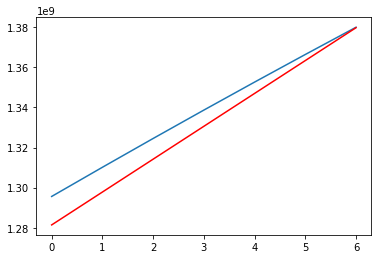

In [357]:
#Predicted vs actual
pyplot.plot(testY)
pyplot.plot( Y_Pred, color='red')
pyplot.show()

We can probably use time series methods to get better accuracy

<h3> Trying out AR </h3>
It's clear from looking at this annual population data that there's no seasonality, but there's an obvious trend. We can probably use a very simple auto regression process to predict this. 

We can look at an auto regressive model as a baseline, and if there's any evidence that this is a moving average process, then we can try an ARMA process as well. 

AD Fuller Test for Stationarity: 

1. In this test the null hypothesis is that the series is not stationary and there is a unit root that causes the variance to not be constant over time 
1. The alternative hypothesis is that the series is stationary 

If the p-value is small then we can reject the null hypothesis and conclude that the series is stationary 

In [145]:
def adf_test(timeseries):
    """
    Code sample taken from 
    https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    
    args:
    
    timeseries: the input time series
    
    This function formats the output of the ADF test for stationarity 
    """
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [151]:
def kpss_test(timeseries):
    """
    Code sample taken from 
    https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    
    args:
    
    timeseries: the input time series
    
    This function formats the output of the KPSS test for stationarity 
    """
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [146]:
adf_test(it['population'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.043953
p-value                         0.736898
#Lags Used                      9.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


Since the p-value is 0.7 (and in common practice we want p to be less than 0.05 so we can get a significance level of 95%) we cannot reject the null hypothesis, and according to this test, the series isn't stationary. 

We would like to run the KPSS test just to be sure. In the KPSS test:

1. The null hypothesis is that the series is stationary 
1. The alternative hypothesis is that there is a unit root and the series is not stationary. 

In [152]:
kpss_test(it['population'])

Results of KPSS Test:
Test Statistic           1.119649
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The p-value in the KPSS test is less than 0.05. This means we can reject the null hypothesis and hence it is confirmed that the series is in fact not stationary. 

Let's look at the autocorrelation and partial autocorrelation plots to see what parameters to use for the AR and MA components of the time series analyses. 

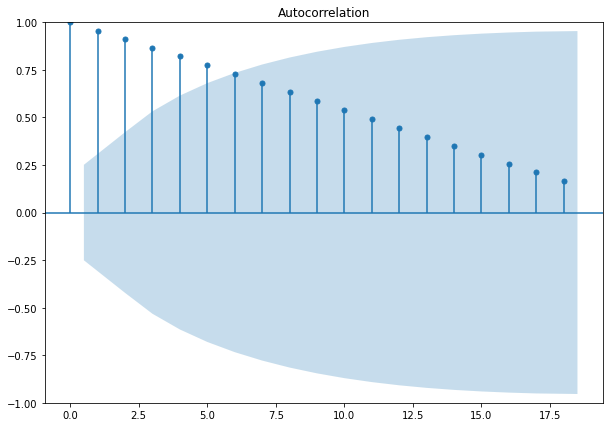

In [181]:
with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(10,7))
    plot_acf(it['population'])
pyplot.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


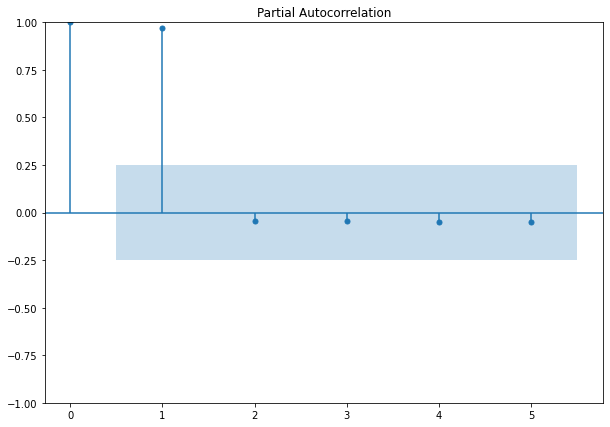

In [183]:
with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(10,7))
    plot_pacf(it['population'],lags=5)
pyplot.show()

From the pacf plot we can tell that there is only 1 significant lag at t=1. We are trying a simple auto regressive model with lag=1 (based on pacf) 

In [391]:
x = it['population']
size = int(len(x) * 0.9)
train,test = x[0:size], x[size:len(x)]
train = train.to_numpy(dtype='float')
train = [i for i in train]
test = test.to_numpy(dtype='float')

In [411]:
#choosing the optimal order with bic
mod = ar_select_order(train, maxlag=17,ic='bic')
mod.ar_lags

[1, 2, 3, 4, 5]

In [412]:
model = ar_model = AutoReg(train, lags=5).fit()
pred = ar_model.predict(start=len(train), end=len(x)-1, dynamic=False)

In [413]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:                     AutoReg(5)   Log Likelihood                -549.009
Method:               Conditional MLE   S.D. of innovations          17770.980
Date:                Fri, 24 Dec 2021   AIC                           1112.018
Time:                        18:15:48   BIC                           1125.260
Sample:                             5   HQIC                          1117.042
                                   54                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.32e+05   3.36e+04      3.933      0.000    6.62e+04    1.98e+05
y.L1           4.1027      0.122     33.530      0.000       3.863       4.343
y.L2          -6.9431      0.455    -15.270      0.000      -7.834      -6.052
y.L3           6.0615      0.672      9.020      0.000       4.744       7.379
y.L4          -2.7022      0.470     -5.746      0.000      -3.624      -1.780
y.L5           0.4809      0.131      3.677      0.000       0.225       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8685           -0.6003j            1.0558           -0.0962
AR.2            0.8685           +0.6003j            1.0558            0.0962
AR.3            0.9896           -0.0328j            0.9901           -0.0053
AR.4            0.9896           +0.0328j            0.9901            0.0053
AR.5            1.9029           -0.0000j            1.9029           -0.0000
-----------------------------------------------------------------------------
"""

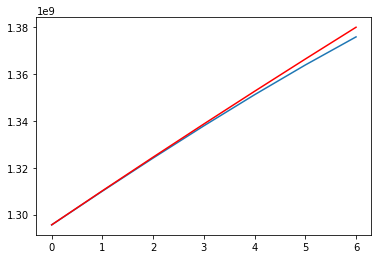

In [414]:
pyplot.plot(pred)
pyplot.plot(test, color='red')

In [415]:
rm_ar = sqrt(mean_squared_error(test, pred))
print('Test RMSE: %.3f' % rm_ar)

Test RMSE: 1940690.879


In [416]:
#calculating goodness of fit
ar_r2 = r2_score(test, pred)
print('R2 score %.3f'%ar_r2)

R2 score 0.995


Auto regressive model with lag=5 has a better goodness of fit than linear regression, but a higher RMSE, hence the linear regression model is still better than the Auto Regressive one in terms of absolute prediction. 